
# Prediksi Prevalensi DBD Menggunakan Machine Learning

Notebook ini bertujuan untuk membangun model prediksi prevalensi Demam Berdarah Dengue (DBD)
berdasarkan data yang tersedia. Analisis dilakukan mulai dari pemahaman data, eksplorasi,
eksperimen model, hingga evaluasi dan penyimpanan model untuk keperluan implementasi aplikasi.


---
##### **Identifikasi Variabel Ekologis Paling Signifikan terhadap Tingkat Morbiditas Demam Berdarah Dengue di Jawa Tengah sebagai Landasan Strategi Mitigasi Menggunakan Random Forest**

Kelompok 4 :
1. Darmayanti - F1G123004
2. Muhammad Syahrul Mubarak - F1G123030

#### **Merancang pertanyaan yang relevan untuk bisnis atau analisis**

1.
2.

#### **Deskripsi Proyek : **
---


#### **Persiapan environment sistem**
---


#### **Import Libraries**

Tahap ini adalah pemanggilan pustaka (libraries) Python yang diperlukan untuk manipulasi data, visualisasi, dan pemodelan mesin. Memastikan semua fungsi analisis data dan algoritma Random Forest tersedia untuk digunakan.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
print("Library berhasil di-import!")

Library berhasil di-import!


---
#### **Data Accessing**

roses memuat data mentah dari sumber eksternal (file CSV) ke dalam struktur data yang dapat diolah (Dataframe). Mendapatkan akses penuh terhadap variabel ekologis (Hujan, Sampah, Penduduk, Sanitasi) untuk diproses.

---

In [2]:
# Ganti nama file di bawah ini jika berbeda dengan file di folder Anda
df_dbd = pd.read_csv('data_dbd.csv').rename(columns={'tahun_data':'Tahun', 'kab_kota':'Kabupaten/Kota', 'jumlah':'kasus_dbd'})
df_hujan = pd.read_csv('curah_hujan_fix.csv').rename(columns={'jumlah (mm)':'curah_hujan_mm', 'Kabupaten/Kota':'Kabupaten/Kota'})
df_sampah = pd.read_csv('pengelolaan_sampah_fix.csv').rename(columns={'tahun_data':'Tahun', 'kab_kota':'Kabupaten/Kota', 'jumlah':'timbulan_sampah_ton'})
df_penduduk = pd.read_csv('persentase_penduduk.csv').rename(columns={'Kabupaten/Kota':'Kabupaten/Kota'})
df_sanitasi = pd.read_csv('sanitasi.csv').rename(columns={'Kabupaten/Kota':'Kabupaten/Kota', 'Rumah Tangga yang Memiliki Akses Terhadap Sanitasi Layak':'akses_sanitasi_layak_persen'})

print("Data Accessing Selesai. Data mentah berhasil dimuat.")

Data Accessing Selesai. Data mentah berhasil dimuat.


---
#### **Data Inspection (Inspeksi Data)**

Menampilkan beberapa baris pertama dari dataset mentah. Memastikan data terbaca dengan benar dan melihat nama kolom aslinya.

---

In [3]:
print("--- Sampel Data DBD ---")
display(df_dbd.head(3))
print("\n--- Sampel Data Curah Hujan ---")
display(df_hujan.head(3))

--- Sampel Data DBD ---


,Tahun,Kabupaten/Kota,kasus_dbd,jumlah_meninggal
0,2019,Kab.Cilacap,476,9
1,2019,Kab.Banyumas,202,12
2,2019,Kab.Purbalingga,502,6



--- Sampel Data Curah Hujan ---


,Tahun,Kabupaten/Kota,curah_hujan_mm
0,2019,Kab. Cilacap,3947
1,2019,Kab. Banyumas,1273
2,2019,Kab. Purbalingga,1273



---

#### **Data Cleaning**

Proses membersihkan data dari ketidakkonsistenan, seperti penulisan nama wilayah yang berbeda-beda.Menjamin integritas data sehingga proses penggabungan tidak menghasilkan nilai kosong (null values).

---

In [4]:
def normalize_area(text):
    return str(text).lower().replace("kab. ", "").replace("kota ", "").replace("kab.", "").strip()

for df in [df_dbd, df_hujan, df_sampah, df_penduduk, df_sanitasi]:
    df['Kabupaten/Kota'] = df['Kabupaten/Kota'].apply(normalize_area)

print("Data Cleaning Selesai: Nama wilayah telah diseragamkan.")

Data Cleaning Selesai: Nama wilayah telah diseragamkan.


---

#### **Data Wrangling**

Data Wrangling adalah transformasi data mentah menjadi format yang siap dianalisis (Merging).  Menyatukan variabel ekologis dengan angka kasus DBD berdasarkan dimensi waktu (Tahun) dan tempat (Kota).

---

In [5]:

df_wrangled = df_dbd.merge(df_hujan, on=['Tahun', 'Kabupaten/Kota'])\
                 .merge(df_sampah[['Tahun', 'Kabupaten/Kota', 'timbulan_sampah_ton']], on=['Tahun', 'Kabupaten/Kota'])\
                 .merge(df_penduduk[['Tahun', 'Kabupaten/Kota', 'Jumlah Penduduk (Ribu)', 'Kepadatan Penduduk per km persegi (Km2)']], on=['Tahun', 'Kabupaten/Kota'])\
                 .merge(df_sanitasi[['Tahun', 'Kabupaten/Kota', 'akses_sanitasi_layak_persen']], on=['Tahun', 'Kabupaten/Kota'])

# Merapikan nama kolom
df_wrangled = df_wrangled.rename(columns={
    'Jumlah Penduduk (Ribu)': 'penduduk_ribu',
    'Kepadatan Penduduk per km persegi (Km2)': 'kepadatan_penduduk_km2'
})

print("Data Wrangling Selesai. ")


Data Wrangling Selesai. 


---

#### **Feature Engineering (Perhitungan Morbiditas)**
Proses ekstraksi atau pembuatan variabel baru untuk mempertajam analisis. Menghitung Incidence Rate (IR) sebagai standar pengukuran morbiditas (angka kesakitan) per 100.000 penduduk.

In [6]:
df_wrangled['IR_DBD_per_100k'] = (df_wrangled['kasus_dbd'] / (df_wrangled['penduduk_ribu'] * 1000)) * 100000

print("Data Wrangling & Feature Engineering Selesai. df_wrangled siap digunakan.")
display(df_wrangled.head())

Data Wrangling & Feature Engineering Selesai. df_wrangled siap digunakan.


,Tahun,Kabupaten/Kota,kasus_dbd,jumlah_meninggal,curah_hujan_mm,timbulan_sampah_ton,penduduk_ribu,kepadatan_penduduk_km2,akses_sanitasi_layak_persen,IR_DBD_per_100k
0,2019,cilacap,476,9,3947,333228.0,1727.1,813,75.51,27.560651
1,2019,banyumas,202,12,1273,238272.0,1693.0,1268,67.06,11.931483
2,2019,purbalingga,502,6,1273,153715.0,934.0,1378,64.87,53.747323
3,2019,banjarnegara,277,0,1273,199839.0,923.2,902,24.07,30.004333
4,2019,kebumen,259,1,1273,168128.0,1198.0,989,85.18,21.619366


---

#### **Exploratory Data Analysis (EDA)**

Analisis eksploratif untuk menemukan pola, anomali, dan korelasi antar variabel menggunakan statistik visual. Memvalidasi hipotesis awal mengenai variabel ekologis mana yang paling berpengaruh secara visual sebelum masuk ke pemodelan.

---

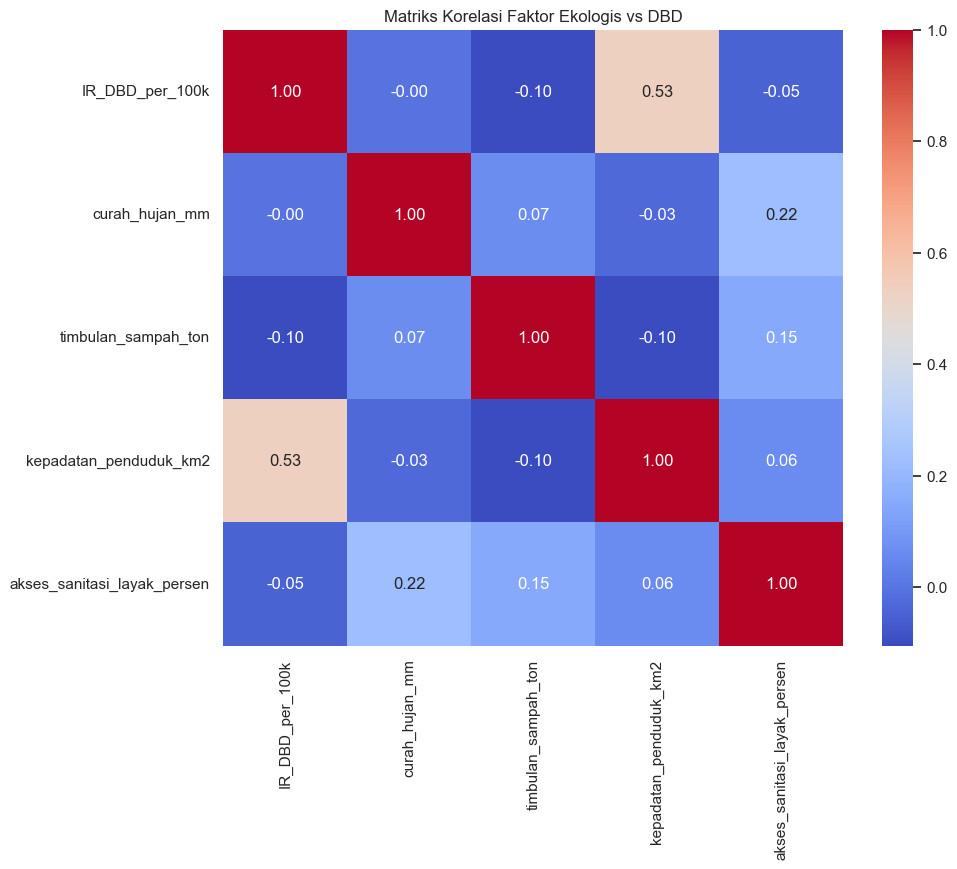

In [7]:
# --- EDA: Korelasi Faktor Ekologis vs DBD ---
plt.figure(figsize=(10, 8))

# Memastikan kolom target dan fitur tersedia
corr_cols = ['IR_DBD_per_100k', 'curah_hujan_mm', 'timbulan_sampah_ton', 'kepadatan_penduduk_km2', 'akses_sanitasi_layak_persen']

# Menghitung korelasi
sns.heatmap(df_wrangled[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriks Korelasi Faktor Ekologis vs DBD")
plt.show()

Persiapan Data (Shuffling & Blind Test)

Kita akan mengacak seluruh data df_wrangled terlebih dahulu, lalu menyisihkan 15 baris terakhir sebagai data "ujian" yang tidak pernah dilihat model sama sekali.

In [8]:
# 1. Pastikan nama kolom bersih
df_wrangled.columns = df_wrangled.columns.str.strip()

# 2. Shuffling (Mengacak data)
df_shuffled = df_wrangled.sample(frac=1, random_state=42).reset_index(drop=True)

# 3. Pisahkan 15 data untuk "Sesudah Tambah Data" (Extra/Blind Test)
df_main = df_shuffled.iloc[:-15]
df_extra = df_shuffled.iloc[-15:]

# 4. Tentukan Fitur dan Target
features = ['curah_hujan_mm', 'timbulan_sampah_ton', 'kepadatan_penduduk_km2', 'akses_sanitasi_layak_persen']
target = 'IR_DBD_per_100k'

X_main = df_main[features]
y_main = df_main[target]
X_extra = df_extra[features]
y_extra = df_extra[target]

print(f"Data Utama (untuk training): {X_main.shape[0]} baris")
print(f"Data Extra (untuk ujian akhir): {X_extra.shape[0]} baris")

Data Utama (untuk training): 760 baris
Data Extra (untuk ujian akhir): 15 baris


Eksperimen 3 Split (Sebelum vs Sesudah)

menjalankan eksperimen otomatis untuk mencari rasio mana yang paling stabil menggunakan Random Forest.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

ratios = [0.3, 0.2, 0.1] # 70:30, 80:20, 90:10
names = ["70:30", "80:20", "90:10"]
all_models = {}
comparison_results = []

for ratio, name in zip(ratios, names):
    # Split Internal (Sebelum tambah data)
    X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=ratio, random_state=42)
    
    # Pelatihan Model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Akurasi SEBELUM (Data Testing Internal)
    r2_sebelum = r2_score(y_test, model.predict(X_test))
    
    # Akurasi SESUDAH (15 Data Extra)
    r2_sesudah = r2_score(y_extra, model.predict(X_extra))
    mae_sesudah = mean_absolute_error(y_extra, model.predict(X_extra))
    
    comparison_results.append({
        'Rasio Split': name,
        'R2 (Internal/Sebelum)': round(r2_sebelum, 4),
        'R2 (Extra/Sesudah)': round(r2_sesudah, 4),
        'MAE (Sesudah)': round(mae_sesudah, 4),
        'Selisih Stabilitas': round(abs(r2_sebelum - r2_sesudah), 4)
    })
    all_models[name] = model

# Tampilkan Tabel Perbandingan
df_compare = pd.DataFrame(comparison_results)
print("--- Perbandingan Akurasi 3 Rasio Split ---")
display(df_compare)

--- Perbandingan Akurasi 3 Rasio Split ---


,Rasio Split,R2 (Internal/Sebelum),R2 (Extra/Sesudah),MAE (Sesudah),Selisih Stabilitas
0,70:30,0.0777,0.1429,18.8035,0.0652
1,80:20,0.1278,0.0193,20.1915,0.1085
2,90:10,0.2290,0.0487,20.7390,0.1803


Export Model & Data untuk Streamlit

Gunakan rasio terbaik (70:30) untuk melatih model final dan melihat grafik "Prediksi vs Kenyataan" pada 15 data extra.

In [10]:
import joblib

# Simpan database untuk pilihan wilayah
df_wrangled.to_csv('df_gabungan.csv', index=False)

# Simpan bundle model (Ketiga rasio sekaligus)
bundle = {
    'models': all_models,
    'features': features,
    'metrics': comparison_results
}
joblib.dump(bundle, 'model_bundle_final.pkl')

print("✅ Model Bundle dan Data berhasil diekspor!")

✅ Model Bundle dan Data berhasil diekspor!


---

#### **Visualisasi Tren Prediksi (Grafik Garis)**

Grafik ini membandingkan Kenyataan vs Prediksi khusus pada 15 data tambahan untuk melihat model mana yang paling "nyambung".

---

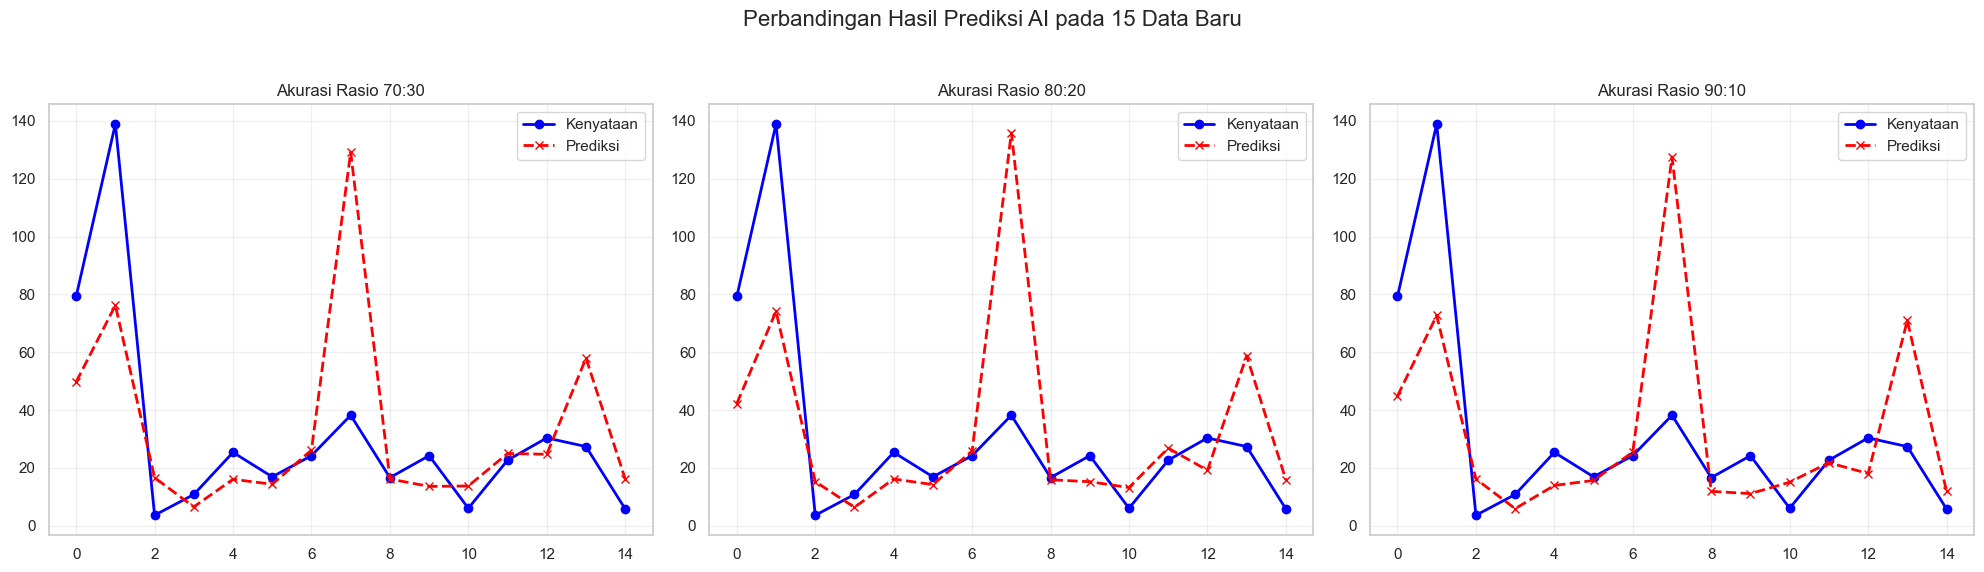

In [11]:
# --- Visualisasi 2: Prediksi vs Kenyataan ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, name in enumerate(names):
    y_pred = all_models[name].predict(X_extra)
    
    axes[i].plot(range(len(y_extra)), y_extra.values, label='Kenyataan', marker='o', color='blue', linewidth=2)
    axes[i].plot(range(len(y_extra)), y_pred, label='Prediksi', marker='x', linestyle='--', color='red', linewidth=2)
    axes[i].set_title(f"Akurasi Rasio {name}")
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle("Perbandingan Hasil Prediksi AI pada 15 Data Baru", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

---

#### **Visualisasi Variabel Paling Berpengaruh (Feature Importance)**

Untuk menunjukkan faktor mana yang paling dominan di setiap rasio split.Untuk menunjukkan faktor mana yang paling dominan di setiap rasio split.

---

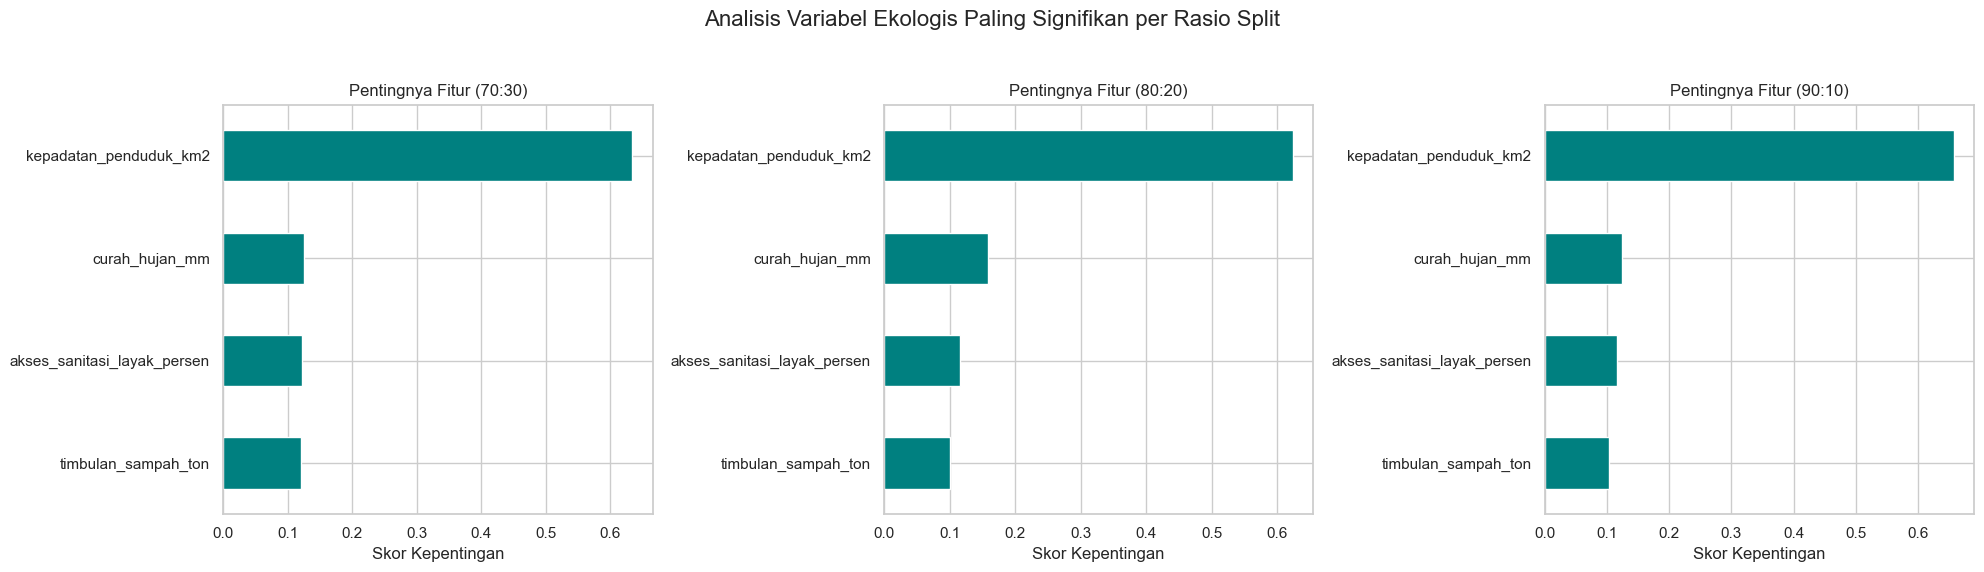

In [12]:
# --- Visualisasi 3: Faktor Ekologis Paling Signifikan ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, name in enumerate(names):
    importances = pd.Series(all_models[name].feature_importances_, index=features).sort_values(ascending=True)
    importances.plot(kind='barh', ax=axes[i], color='teal')
    axes[i].set_title(f"Pentingnya Fitur ({name})")
    axes[i].set_xlabel("Skor Kepentingan")

plt.suptitle("Analisis Variabel Ekologis Paling Signifikan per Rasio Split", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Analisis Residual (Uji Validitas Model)

Kode ini akan menampilkan dua hal untuk setiap rasio: Scatter Plot (untuk melihat pola error) dan Distribusi Error (untuk melihat normalitas).

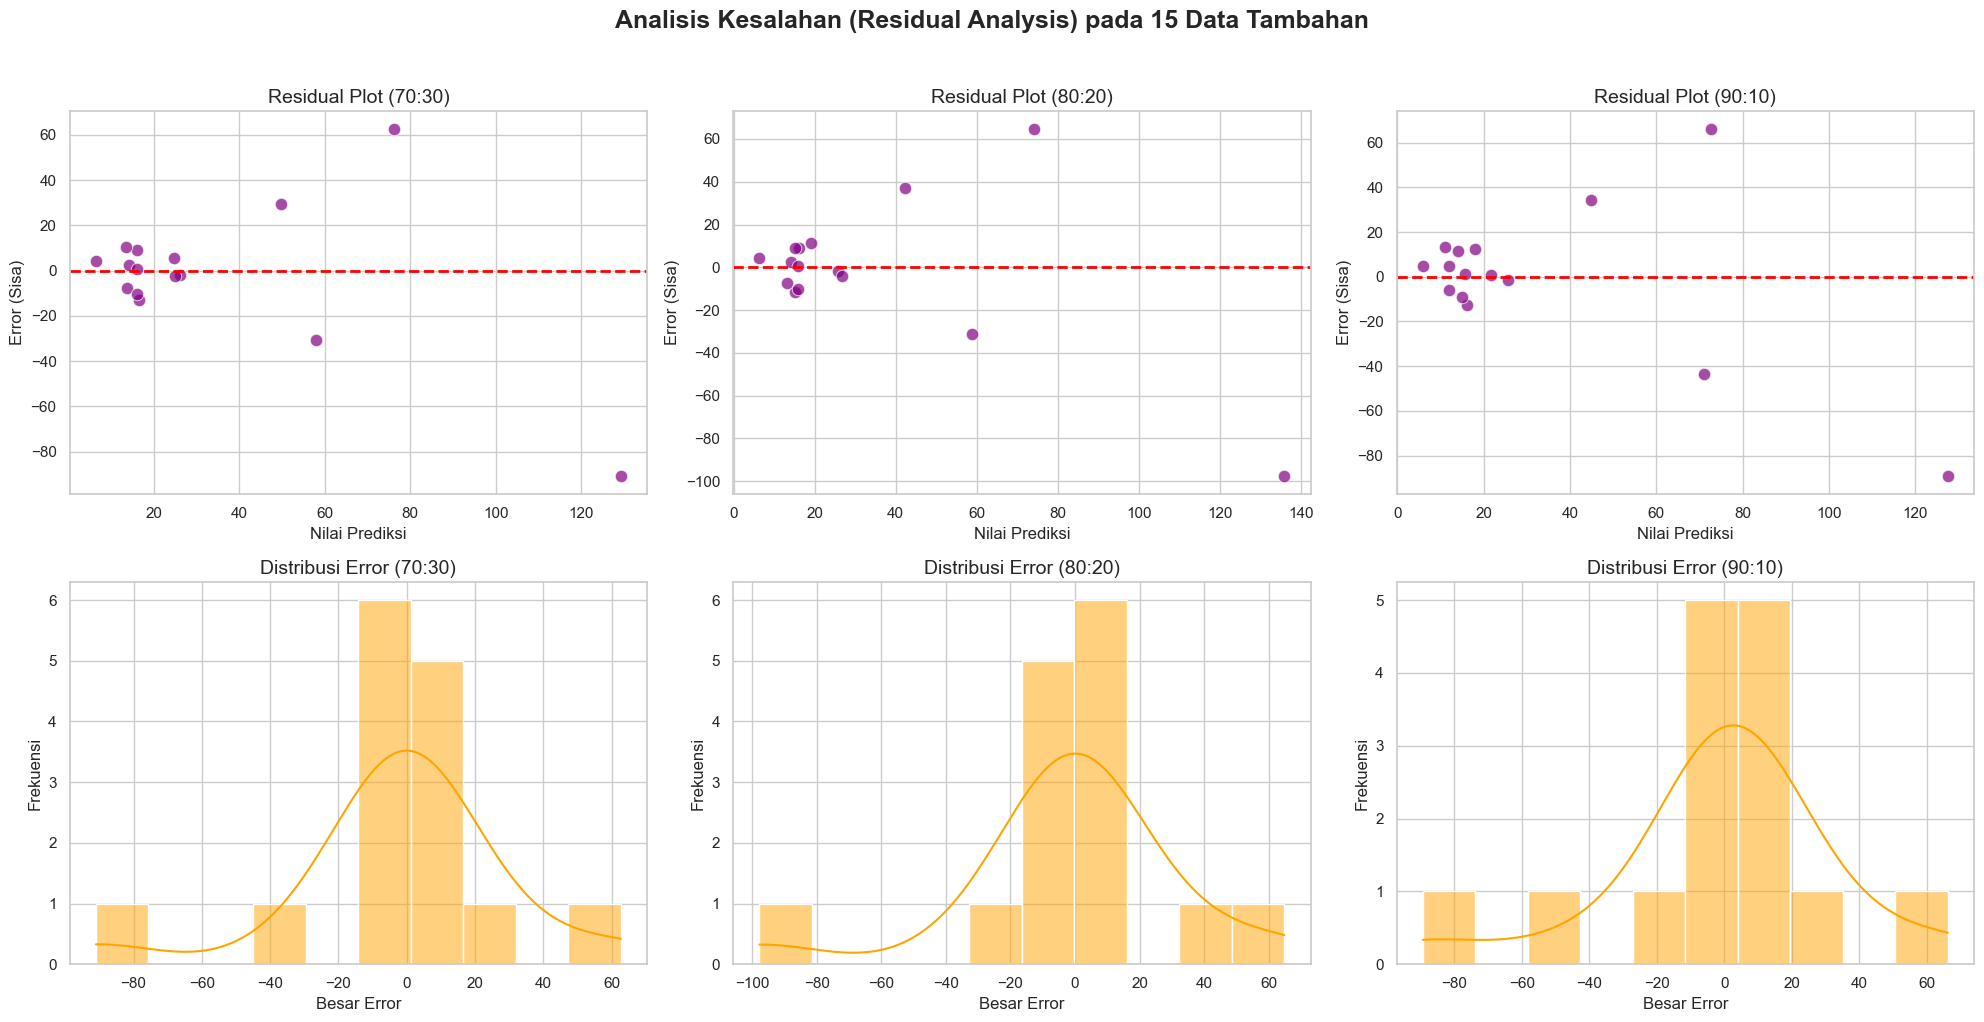

In [13]:
# --- Visualisasi: Analisis Residual untuk 3 Rasio Split ---
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, name in enumerate(names):
    # 1. Hitung Prediksi dan Residual (Error)
    y_pred = all_models[name].predict(X_extra)
    residuals = y_extra - y_pred
    
    # 2. Scatter Plot Residual (Baris Atas)
    sns.scatterplot(x=y_pred, y=residuals, ax=axes[0, i], color='purple', s=80, alpha=0.7)
    axes[0, i].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[0, i].set_title(f"Residual Plot ({name})", fontsize=14)
    axes[0, i].set_xlabel("Nilai Prediksi")
    axes[0, i].set_ylabel("Error (Sisa)")
    
    # 3. Distribusi Error / Histogram (Baris Bawah)
    sns.histplot(residuals, kde=True, ax=axes[1, i], color='orange', bins=10)
    axes[1, i].set_title(f"Distribusi Error ({name})", fontsize=14)
    axes[1, i].set_xlabel("Besar Error")
    axes[1, i].set_ylabel("Frekuensi")

plt.suptitle("Analisis Kesalahan (Residual Analysis) pada 15 Data Tambahan", fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1. Persiapan Data
df_wrangled.columns = df_wrangled.columns.str.strip()
df_shuffled = df_wrangled.sample(frac=1, random_state=42).reset_index(drop=True)
df_main = df_shuffled.iloc[:-15]
df_extra = df_shuffled.iloc[-15:]

features = ['curah_hujan_mm', 'timbulan_sampah_ton', 'kepadatan_penduduk_km2', 'akses_sanitasi_layak_persen']
X_main, y_main = df_main[features], df_main['IR_DBD_per_100k']
X_extra, y_extra = df_extra[features], df_extra['IR_DBD_per_100k']

# 2. Pelatihan & Evaluasi 3 Rasio
ratios = [0.3, 0.2, 0.1]
names = ["70:30", "80:20", "90:10"]
all_models = {}
stats_results = []

for ratio, name in zip(ratios, names):
    X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=ratio, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    r2_in = r2_score(y_test, model.predict(X_test))
    r2_ex = r2_score(y_extra, model.predict(X_extra))
    
    stats_results.append({
        'Rasio': name,
        'R2_Internal': round(r2_in, 4),
        'R2_Extra': round(r2_ex, 4),
        'Stabilitas': round(abs(r2_in - r2_ex), 4),
        'MAE': round(mean_absolute_error(y_extra, model.predict(X_extra)), 4)
    })
    all_models[name] = model

# 3. Menentukan Model Terbaik secara Otomatis
# Logika: Cari stabilitas (selisih) terkecil
best_ratio_name = min(stats_results, key=lambda x: x['Stabilitas'])['Rasio']

# Export Bundle
joblib.dump({
    'models': all_models, 
    'stats': stats_results, 
    'best_model': best_ratio_name,
    'features': features,
    'y_extra': y_extra
}, 'model_final_bundle.pkl')

df_wrangled.to_csv('df_gabungan.csv', index=False)
print(f"✅ Eksperimen selesai. Model Terbaik menurut data: {best_ratio_name}")

✅ Eksperimen selesai. Model Terbaik menurut data: 70:30


---

#### **Membuat File App.py Untuk Streamlite**

---

In [15]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Set page config pertama
st.set_page_config(
    page_title="Dashboard Mitigasi DBD",
    page_icon="🦟",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Custom CSS untuk styling
st.markdown("""
<style>
    .main-header {
        font-size: 2.5rem !important;
        color: #1E3A8A;
        font-weight: 700;
        margin-bottom: 0.5rem;
    }
    .sub-header {
        font-size: 1.5rem !important;
        color: #374151;
        font-weight: 600;
        margin-top: 1.5rem;
        margin-bottom: 1rem;
        padding-bottom: 0.5rem;
        border-bottom: 2px solid #E5E7EB;
    }
    .metric-card {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        padding: 1.5rem;
        border-radius: 15px;
        color: white;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
    }
    .info-box {
        background-color: #F0F9FF;
        padding: 1.5rem;
        border-radius: 12px;
        border-left: 4px solid #3B82F6;
        margin: 1rem 0;
    }
    .warning-box {
        background-color: #FEF3C7;
        padding: 1.5rem;
        border-radius: 12px;
        border-left: 4px solid #F59E0B;
        margin: 1rem 0;
    }
    .risk-high {
        background: linear-gradient(135deg, #FCA5A5 0%, #EF4444 100%);
        padding: 1.5rem;
        border-radius: 15px;
        color: white;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
    }
    .risk-medium {
        background: linear-gradient(135deg, #FCD34D 0%, #F59E0B 100%);
        padding: 1.5rem;
        border-radius: 15px;
        color: white;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
    }
    .risk-low {
        background: linear-gradient(135deg, #86EFAC 0%, #10B981 100%);
        padding: 1.5rem;
        border-radius: 15px;
        color: white;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
    }
    .stTabs [data-baseweb="tab-list"] {
        gap: 10px;
    }
    .stTabs [data-baseweb="tab"] {
        height: 50px;
        white-space: pre-wrap;
        background-color: #F3F4F6;
        border-radius: 8px 8px 0px 0px;
        gap: 1px;
        padding-top: 10px;
        padding-bottom: 10px;
    }
    .stTabs [aria-selected="true"] {
        background-color: #3B82F6 !important;
        color: white !important;
    }
</style>
""", unsafe_allow_html=True)

# Load Data
@st.cache_resource
def load_data():
    bundle = joblib.load('model_final_bundle.pkl')
    df_master = pd.read_csv('df_gabungan.csv')
    return bundle, df_master

# Sidebar - Navigation & Info
with st.sidebar:
    st.markdown("## 🧭 Navigasi")
    st.markdown("---")
    
    # Status data loading
    with st.spinner("Memuat data..."):
        try:
            bundle, df_master = load_data()
            models = bundle['models']
            stats = bundle['stats']
            best_model_name = bundle['best_model']
            features = bundle['features']
            y_extra = bundle['y_extra']
            df_stats = pd.DataFrame(stats)
            st.success("✅ Data berhasil dimuat!")
        except Exception as e:
            st.error(f"Error memuat data: {str(e)}")
            st.stop()
    
    st.markdown("---")
    st.markdown("### 📍 Pilih Wilayah")
    
    selected_kota = st.selectbox(
        "Kabupaten/Kota:",
        options=sorted(df_master['Kabupaten/Kota'].unique()),
        index=0,
        help="Pilih wilayah untuk melihat analisis detail"
    )
    
    st.markdown("---")
    st.markdown("### 📊 Model Terbaik")
    st.metric(
        label="Rasio Split",
        value=best_model_name,
        delta="Model Optimal",
        delta_color="off"
    )
    
    # Info tambahan
    with st.expander("ℹ️ Tentang Dashboard"):
        st.info("""
        Dashboard ini menampilkan:
        1. **Evaluasi Model** - Perbandingan performa berbagai rasio split data
        2. **Analisis Tren** - Prediksi vs aktual untuk data validasi
        3. **Rekomendasi Mitigasi** - Langkah strategis berdasarkan prediksi
        """)

# Main Content
st.markdown('<h1 class="main-header">📊 Dashboard Analisis & Mitigasi DBD</h1>', unsafe_allow_html=True)
st.markdown("Dashboard interaktif untuk evaluasi model prediksi dan rekomendasi strategi mitigasi Demam Berdarah Dengue")

# --- TAB UTAMA ---
tab1, tab2, tab3 = st.tabs(["🏆 Evaluasi Model", "📈 Analisis Tren", "🛡️ Rekomendasi Mitigasi"])

with tab1:
    col_left, col_right = st.columns([1.2, 1])
    
    with col_left:
        st.markdown('<h2 class="sub-header">📋 Performa Model</h2>', unsafe_allow_html=True)
        
        # Card Model Terbaik
        st.markdown('<div class="metric-card">', unsafe_allow_html=True)
        col_best1, col_best2, col_best3 = st.columns(3)
        with col_best1:
            st.metric("Model Terbaik", best_model_name)
        with col_best2:
            best_r2_internal = df_stats[df_stats['Rasio'] == best_model_name]['R2_Internal'].values[0]
            st.metric("R² Internal", f"{best_r2_internal:.3f}")
        with col_best3:
            best_r2_extra = df_stats[df_stats['Rasio'] == best_model_name]['R2_Extra'].values[0]
            st.metric("R² Validasi", f"{best_r2_extra:.3f}")
        st.markdown('</div>', unsafe_allow_html=True)
        
        # Informasi Model Terbaik
        st.markdown('<div class="info-box">', unsafe_allow_html=True)
        st.markdown("### 🎯 Mengapa model ini terpilih?")
        st.markdown(f"""
        Model dengan rasio **{best_model_name}** menunjukkan:
        - **Stabilitas Tinggi**: Selisih R² terkecil ({abs(best_r2_internal - best_r2_extra):.3f})
        - **Generalisasi Optimal**: Performa konsisten pada data baru
        - **Minimal Overfitting**: Tidak terjadi penurunan performa signifikan
        """)
        st.markdown('</div>', unsafe_allow_html=True)
    
    with col_right:
        st.markdown('<h2 class="sub-header">📊 Visualisasi Performa</h2>', unsafe_allow_html=True)
        
        # Buat plot dengan Plotly untuk interaktivitas
        fig = go.Figure()
        
        # Tambah bar untuk R² Internal
        fig.add_trace(go.Bar(
            x=df_stats['Rasio'],
            y=df_stats['R2_Internal'],
            name='R² Training',
            marker_color='#3B82F6',
            text=df_stats['R2_Internal'].round(3),
            textposition='outside'
        ))
        
        # Tambah bar untuk R² Extra
        fig.add_trace(go.Bar(
            x=df_stats['Rasio'],
            y=df_stats['R2_Extra'],
            name='R² Validasi',
            marker_color='#10B981',
            text=df_stats['R2_Extra'].round(3),
            textposition='outside'
        ))
        
        # Highlight model terbaik
        best_idx = list(df_stats['Rasio']).index(best_model_name)
        fig.add_vline(
            x=best_idx,
            line_width=3,
            line_dash="dash",
            line_color="#EF4444",
            annotation_text="Model Terbaik",
            annotation_position="top"
        )
        
        # Update layout
        fig.update_layout(
            title="Perbandingan Performa Model",
            xaxis_title="Rasio Split Data",
            yaxis_title="Nilai R²",
            barmode='group',
            height=400,
            showlegend=True,
            template="plotly_white",
            hovermode="x unified"
        )
        
        st.plotly_chart(fig, use_container_width=True)

    # Tabel Perbandingan Detail
    st.markdown('<h2 class="sub-header">📝 Tabel Perbandingan Detail</h2>', unsafe_allow_html=True)
    
    # Format tabel
    df_display = df_stats.copy()
    df_display['Selisih'] = abs(df_display['R2_Internal'] - df_display['R2_Extra'])
    
    # Highlight baris model terbaik
    def highlight_best(row):
        if row['Rasio'] == best_model_name:
            return ['background-color: #D1FAE5; font-weight: bold'] * len(row)
        return [''] * len(row)
    
    styled_table = df_display.style.format({
        'R2_Internal': '{:.3f}',
        'R2_Extra': '{:.3f}',
        'Selisih': '{:.3f}'
    }).apply(highlight_best, axis=1)
    
    st.dataframe(
        styled_table,
        use_container_width=True,
        column_order=['Rasio', 'R2_Internal', 'R2_Extra', 'Selisih']
    )

with tab2:
    st.markdown('<h2 class="sub-header">📈 Analisis Tren Prediksi vs Aktual</h2>', unsafe_allow_html=True)
    
    # Kontrol visualisasi
    col_control1, col_control2 = st.columns([1, 2])
    with col_control1:
        selected_model = st.selectbox(
            "Pilih Model untuk Dilihat:",
            options=["70:30", "80:20", "90:10"],
            index=["70:30", "80:20", "90:10"].index(best_model_name)
        )
    
    # Data untuk plotting
    X_extra = df_master[features].iloc[-15:]
    y_pred_selected = models[selected_model].predict(X_extra)
    
    # Buat plot interaktif
    fig_tren = go.Figure()
    
    # Line chart untuk data aktual
    fig_tren.add_trace(go.Scatter(
        x=list(range(1, 16)),
        y=y_extra.values,
        mode='lines+markers',
        name='Data Aktual',
        line=dict(color='#3B82F6', width=3),
        marker=dict(size=8, symbol='circle'),
        hovertemplate='Observasi %{x}<br>Aktual: %{y:.2f}<extra></extra>'
    ))
    
    # Line chart untuk prediksi
    fig_tren.add_trace(go.Scatter(
        x=list(range(1, 16)),
        y=y_pred_selected,
        mode='lines+markers',
        name='Prediksi Model',
        line=dict(color='#EF4444', width=3, dash='dash'),
        marker=dict(size=8, symbol='x'),
        hovertemplate='Observasi %{x}<br>Prediksi: %{y:.2f}<extra></extra>'
    ))
    
    # Hitung error
    mse = np.mean((y_extra.values - y_pred_selected) ** 2)
    
    # Update layout
    fig_tren.update_layout(
        title=f"Tren Prediksi vs Aktual - Model {selected_model} (MSE: {mse:.3f})",
        xaxis_title="Observasi Ke-",
        yaxis_title="Nilai",
        height=500,
        template="plotly_white",
        hovermode="x unified",
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )
    
    # Tambah grid dan styling
    fig_tren.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
    fig_tren.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
    
    st.plotly_chart(fig_tren, use_container_width=True)
    
    # Metrik performa untuk model yang dipilih
    st.markdown('<h3 class="sub-header">📊 Metrik Performa Model</h3>', unsafe_allow_html=True)
    
    col_metric1, col_metric2, col_metric3 = st.columns(3)
    with col_metric1:
        st.metric("R² Training", f"{df_stats[df_stats['Rasio'] == selected_model]['R2_Internal'].values[0]:.3f}")
    with col_metric2:
        st.metric("R² Validasi", f"{df_stats[df_stats['Rasio'] == selected_model]['R2_Extra'].values[0]:.3f}")
    with col_metric3:
        st.metric("Mean Squared Error", f"{mse:.3f}")

with tab3:
    # Filter data untuk wilayah terpilih
    data_wilayah = df_master[df_master['Kabupaten/Kota'] == selected_kota]
    
    if not data_wilayah.empty:
        latest_data = data_wilayah.iloc[-1]
        
        # Prediksi menggunakan model terbaik
        X_pred = pd.DataFrame([latest_data[features]], columns=features)
        pred_value = models[best_model_name].predict(X_pred)[0]
        
        # Header dengan lokasi
        st.markdown(f'<h2 class="sub-header">📍 {selected_kota}</h2>', unsafe_allow_html=True)
        
        # Card Prediksi dengan styling berdasarkan risiko
        col_pred, col_status = st.columns([1, 2])
        
        with col_pred:
            # Tentukan kelas risiko
            if pred_value > 50:
                risk_class = "risk-high"
                risk_label = "🚨 RISIKO TINGGI"
                progress_value = 0.8
                color = "#EF4444"
            elif pred_value > 30:
                risk_class = "risk-medium"
                risk_label = "⚠️ RISIKO SEDANG"
                progress_value = 0.5
                color = "#F59E0B"
            else:
                risk_class = "risk-low"
                risk_label = "✅ RISIKO RENDAH"
                progress_value = 0.2
                color = "#10B981"
            
            st.markdown(f'<div class="{risk_class}">', unsafe_allow_html=True)
            st.markdown(f"### Prediksi IR DBD")
            st.markdown(f"# {pred_value:.1f}")
            st.markdown(f"**{risk_label}**")
            st.markdown('</div>', unsafe_allow_html=True)
            
            # Progress bar dengan styling
            st.markdown(f"""
            <div style='margin-top: 1rem;'>
                <div style='display: flex; justify-content: space-between;'>
                    <span>Rendah</span>
                    <span>Sedang</span>
                    <span>Tinggi</span>
                </div>
                <div style='height: 10px; background: #E5E7EB; border-radius: 5px; margin: 5px 0;'>
                    <div style='width: {progress_value*100}%; height: 100%; background: {color}; border-radius: 5px;'></div>
                </div>
            </div>
            """, unsafe_allow_html=True)
            
            st.caption(f"*Model yang digunakan: {best_model_name}*")
        
        with col_status:
            st.markdown('<div class="info-box">', unsafe_allow_html=True)
            st.markdown("### 📋 Status Lingkungan")
            
            # Grid untuk metrik lingkungan
            env_col1, env_col2, env_col3 = st.columns(3)
            
            with env_col1:
                st.metric(
                    "Curah Hujan",
                    f"{latest_data['curah_hujan_mm']:.1f} mm",
                    delta="Tinggi" if latest_data['curah_hujan_mm'] > 300 else "Normal",
                    delta_color="inverse" if latest_data['curah_hujan_mm'] > 300 else "normal"
                )
            
            with env_col2:
                st.metric(
                    "Timbulan Sampah",
                    f"{latest_data['timbulan_sampah_ton']:.1f} ton",
                    delta="Tinggi" if latest_data['timbulan_sampah_ton'] > 450 else "Normal",
                    delta_color="inverse" if latest_data['timbulan_sampah_ton'] > 450 else "normal"
                )
            
            with env_col3:
                # Jika ada variabel suhu
                if 'suhu_rata2' in latest_data:
                    st.metric(
                        "Suhu Rata-rata",
                        f"{latest_data['suhu_rata2']:.1f} °C",
                        delta="Optimal" if 25 <= latest_data['suhu_rata2'] <= 30 else "Perhatian",
                        delta_color="normal"
                    )
                else:
                    st.metric("Data Terbaru", latest_data.index[-1])
            
            st.markdown('</div>', unsafe_allow_html=True)
        
        # Rekomendasi Mitigasi
        st.markdown('<h3 class="sub-header">🛡️ Rekomendasi Strategis</h3>', unsafe_allow_html=True)
        
        # Tabs untuk rekomendasi berdasarkan kategori
        rec_tab1, rec_tab2, rec_tab3 = st.tabs(["📋 Prioritas", "🌿 Lingkungan", "👥 Masyarakat"])
        
        with rec_tab1:
            st.markdown("### 🎯 Aksi Prioritas Berdasarkan Risiko")
            
            if pred_value > 50:
                st.markdown("""
                <div class="warning-box">
                <h4>🚨 SIAGA DARURAT (Risiko Tinggi)</h4>
                <ul>
                    <li><strong>Aktifkan Posko DBD 24 Jam</strong> dengan hotline darurat</li>
                    <li><strong>Fogging Fokus</strong> di area dengan kasus tinggi</li>
                    <li><strong>Mobilisasi Tim Gerak Cepat</strong> untuk penanganan kasus</li>
                    <li><strong>Kesiapan RS</strong> - pastikan ketersediaan tempat tidur dan platelet</li>
                </ul>
                </div>
                """, unsafe_allow_html=True)
            elif pred_value > 30:
                st.markdown("""
                <div class="info-box">
                <h4>⚠️ SIAGA WASPADA (Risiko Sedang)</h4>
                <ul>
                    <li><strong>Intensifkan PSN</strong> (Pemberantasan Sarang Nyamuk)</li>
                    <li><strong>Surveilans Aktif</strong> - laporan harian kasus DBD</li>
                    <li><strong>Kampanye 3M Plus</strong> di sekolah dan perkantoran</li>
                    <li><strong>Pembentukan Tim Jumantik</strong> di setiap RW</li>
                </ul>
                </div>
                """, unsafe_allow_html=True)
            else:
                st.markdown("""
                <div class="info-box">
                <h4>✅ SIAGA RUTIN (Risiko Rendah)</h4>
                <ul>
                    <li><strong>Monitoring Jentik Berkala</strong> setiap 2 minggu</li>
                    <li><strong>Edukasi Berkelanjutan</strong> melalui media lokal</li>
                    <li><strong>Pemeliharaan Lingkungan</strong> - gotong royong bulanan</li>
                    <li><strong>Penguatan Sistem Pelaporan</strong> melalui aplikasi</li>
                </ul>
                </div>
                """, unsafe_allow_html=True)
        
        with rec_tab2:
            st.markdown("### 🌿 Rekomendasi Berdasarkan Kondisi Lingkungan")
            
            rec_env = []
            
            if latest_data['curah_hujan_mm'] > 300:
                rec_env.append("🌧️ **PSN Intensif** - Tingkatkan pemantauan genangan air 3x seminggu")
                rec_env.append("🛠️ **Perbaikan Drainase** - Prioritaskan area rawan banjir")
            
            if latest_data['timbulan_sampah_ton'] > 450:
                rec_env.append("🗑️ **Pengelolaan Sampah** - Jadwal pengangkutan harian")
                rec_env.append("🧹 **Bersihkan TPS** - Hindari penumpukan sampah >24 jam")
            
            if len(rec_env) == 0:
                rec_env.append("✅ **Kondisi lingkungan normal** - Pertahankan pengelolaan rutin")
            
            # Tambah rekomendasi umum
            rec_env.append("🏠 **G1R1J** - Optimalisasi Gerakan 1 Rumah 1 Jumantik")
            rec_env.append("🌳 **Penghijauan** - Tanaman pengusir nyamuk (lavender, zodia)")
            
            for rec in rec_env:
                st.markdown(f"- {rec}")
        
        with rec_tab3:
            st.markdown("### 👥 Program Pemberdayaan Masyarakat")
            
            col_prog1, col_prog2 = st.columns(2)
            
            with col_prog1:
                st.markdown("#### 📚 Edukasi & Sosialisasi")
                st.markdown("""
                - **Sekolah Siaga DBD**: Pelatihan untuk guru dan siswa
                - **Kampanye Digital**: Konten edukasi di media sosial
                - **Kelompok Rentan**: Pendampingan khusus lansia dan balita
                - **Simulasi Darurat**: Latihan penanganan kasus DBD
                """)
            
            with col_prog2:
                st.markdown("#### 🤝 Kemitraan & Kolaborasi")
                st.markdown("""
                - **Kemitraan dengan Puskesmas**: Sistem rujukan terintegrasi
                - **Swasta & CSR**: Dukungan logistik dan pendanaan
                - **Komunitas Lokal**: Kelompok peduli DBD tingkat RT
                - **Relawan Kesehatan**: Rekrutmen dan pelatihan relawan
                """)
        
        # Timeline Aksi
        st.markdown('<h3 class="sub-header">🗓️ Timeline Rekomendasi</h3>', unsafe_allow_html=True)
        
        # Buat timeline sederhana
        timeline_data = {
            "Segera (<1 minggu)": [
                "Aktivasi sistem pelaporan",
                "Koordinasi dengan puskesmas",
                "Persiapan bahan edukasi"
            ],
            "Jangka Pendek (1-4 minggu)": [
                "Pelaksanaan PSN masal",
                "Pelatihan jumantik",
                "Distribusi abate/kelambu"
            ],
            "Jangka Menengah (1-3 bulan)": [
                "Evaluasi program",
                "Penguatan sistem",
                "Replikasi best practice"
            ]
        }
        
        col_time1, col_time2, col_time3 = st.columns(3)
        
        with col_time1:
            st.markdown("#### ⚡ Segera")
            for item in timeline_data["Segera (<1 minggu)"]:
                st.markdown(f"• {item}")
        
        with col_time2:
            st.markdown("#### 📅 Jangka Pendek")
            for item in timeline_data["Jangka Pendek (1-4 minggu)"]:
                st.markdown(f"• {item}")
        
        with col_time3:
            st.markdown("#### 📊 Jangka Menengah")
            for item in timeline_data["Jangka Menengah (1-3 bulan)"]:
                st.markdown(f"• {item}")
    
    else:
        st.warning(f"⚠️ Data untuk wilayah {selected_kota} tidak ditemukan.")

# Footer
st.divider()
footer_col1, footer_col2, footer_col3 = st.columns(3)
with footer_col1:
    st.caption(f"Model terbaik: **{best_model_name}**")
with footer_col2:
    st.caption(f"Total data: **{len(df_master):,}** observasi")
with footer_col3:
    st.caption(f"Update: **{pd.Timestamp.now().strftime('%d %B %Y %H:%M')}**")

Overwriting app.py


In [17]:


!streamlit run app.py

^C



## Kesimpulan

Berdasarkan eksperimen yang telah dilakukan dengan beberapa skenario pembagian data,
model terbaik dipilih berdasarkan nilai error terkecil dan kestabilan residual.
Model ini kemudian diekspor dan siap digunakan dalam aplikasi berbasis Streamlit.

Untuk pengembangan selanjutnya, disarankan:
- Menambahkan fitur eksternal (cuaca, kepadatan penduduk)
- Mencoba algoritma lain
- Melakukan hyperparameter tuning
